<a href="https://colab.research.google.com/github/Nehach73/DS3001_project_voting/blob/main/Project_Notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Voting

**Group 2: Randa Ampah, Neha Channamraju, Rebekah Weaver, Faith Koobial, Gian Baez, Aysha Hussen**

In [1]:
# Importing the necessary libraries
import geopandas as gpd
!pip install mapclassify
import mapclassify
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona

In [97]:
# Loading in the data
! git clone https://github.com/Nehach73/DS3001_project_voting.git

voting = pd.read_csv('DS3001_project_voting/data/voting_VA.csv')
voting = voting.drop(columns=['Unnamed: 0', 'state', 'state_po', 'office', 'version', 'mode'], axis=1)
voting.head()

fatal: destination path 'DS3001_project_voting' already exists and is not an empty directory.


,year,county_name,county_fips,candidate,party,candidatevotes,totalvotes
0,2000,ACCOMACK,51001,AL GORE,DEMOCRAT,5092,11925
1,2000,ACCOMACK,51001,GEORGE W. BUSH,REPUBLICAN,6352,11925
2,2000,ACCOMACK,51001,RALPH NADER,GREEN,220,11925
3,2000,ACCOMACK,51001,OTHER,OTHER,261,11925
4,2000,ALBEMARLE,51003,AL GORE,DEMOCRAT,16255,36846


In [98]:
counties = pd.read_csv('DS3001_project_voting/data/county_adjacencies.csv')
counties = counties.rename(columns={'County':'county_name', 'FIPS':'county_fips'})
counties['county_name'] = counties['county_name'].str.upper()
counties.head()

,county_name,Population2022,county_fips,District,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12
0,ACCOMACK,33191,51001,2,Northumberland,Lancaster,Middlesex,Mathews,Northampton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALBEMARLE,114534,51003,5,CharlottesvilleCity,Nelson,Augusta,Rockingham,Greene,Orange,Louisa,Fluvanna,Buckingham,Nelson,NaN,NaN
2,ALEXANDRIACITY,155525,51510,8,Fairfax,Arlington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALLEGHANY,14835,51005,6,Craig,Bath,Botetourt,CovingtonCity,Rockbridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AMELIA,13455,51007,5,PrinceEdward,Cumberland,Powhatan,Chesterfield,Dinwiddie,Nottoway,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# Combining both datasets
voting = pd.merge(voting, counties, on=['county_name','county_fips'], how='right')
voting.head()

,year,county_name,county_fips,candidate,party,candidatevotes,totalvotes,Population2022,District,N1,...,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12
0,2000.0,ACCOMACK,51001,AL GORE,DEMOCRAT,5092.0,11925.0,33191,2,Northumberland,...,Middlesex,Mathews,Northampton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000.0,ACCOMACK,51001,GEORGE W. BUSH,REPUBLICAN,6352.0,11925.0,33191,2,Northumberland,...,Middlesex,Mathews,Northampton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000.0,ACCOMACK,51001,RALPH NADER,GREEN,220.0,11925.0,33191,2,Northumberland,...,Middlesex,Mathews,Northampton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000.0,ACCOMACK,51001,OTHER,OTHER,261.0,11925.0,33191,2,Northumberland,...,Middlesex,Mathews,Northampton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004.0,ACCOMACK,51001,JOHN KERRY,DEMOCRAT,5518.0,13356.0,33191,2,Northumberland,...,Middlesex,Mathews,Northampton,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
# Finding significant variables for the model
voting_vars = voting[['year', 'county_name', 'county_fips', 'Population2022', 'District']]
voting_vars = voting_vars.loc[(voting["party"] == "DEMOCRAT"),:] # removing duplicates
voting_vars.head()

# 2020 entries are showing up thrice, but every other year only shows up once
# Leaving this in could help weigh people's decision about the last election higher in our model

,year,county_name,county_fips,Population2022,District
0,2000.0,ACCOMACK,51001,33191,2
4,2004.0,ACCOMACK,51001,33191,2
7,2008.0,ACCOMACK,51001,33191,2
10,2012.0,ACCOMACK,51001,33191,2
13,2016.0,ACCOMACK,51001,33191,2


In [104]:
# defining election result as the difference between dem and rep votes
votes = pd.DataFrame()
dem_votes = voting.loc[(voting["party"] == "DEMOCRAT"),:].groupby(['county_name', 'year'])["candidatevotes"].sum()
votes['dem_votes'] = dem_votes

rep_votes = voting.loc[(voting["party"] == "REPUBLICAN"),:].groupby(['county_name', 'year'])["candidatevotes"].sum()
votes['rep_votes'] = rep_votes

voting_vars = pd.merge(voting_vars, votes, on=['county_name', 'year'], how='right')
voting_vars['result'] = voting_vars['dem_votes']-voting_vars['rep_votes']

In [109]:
voting_vars.head()

,year,county_name,county_fips,Population2022,District,dem_votes,rep_votes,result
0,2000.0,ACCOMACK,51001,33191,2,5092.0,6352.0,-1260.0
1,2004.0,ACCOMACK,51001,33191,2,5518.0,7726.0,-2208.0
2,2008.0,ACCOMACK,51001,33191,2,7607.0,7833.0,-226.0
3,2012.0,ACCOMACK,51001,33191,2,7655.0,8213.0,-558.0
4,2016.0,ACCOMACK,51001,33191,2,6740.0,8583.0,-1843.0


In [111]:
import altair as alt
alt.Chart(voting_vars).mark_line().encode(
    alt.X('year:T'),
    alt.Y('result:Q'),
    color='county_name'
).properties(width=600)

alt.Chart(...)

In [ ]:
# Cleaning votes for map
#voting_2022 = voting.loc[voting["year"] == 2020,:] #collect 2022 data

#dem_voting_2022 = voting_2022.loc[(voting_2022["party"] == "DEMOCRAT"),:].groupby("county_fips")["candidatevotes"].sum()
#dem_voting_2022 = dem_voting_2022.rename("dem_votes_2022")
#df = voting.merge(dem_voting_2022, left_on="Population2022", right_on="county_fips")

#rep_voting_2022 = voting_2022.loc[(voting_2022["party"] == "REPUBLICAN"),:].groupby("county_fips")["candidatevotes"].sum()
#rep_voting_2022 = rep_voting_2022.rename("rep_votes_2022")

#df = df.merge(rep_voting_2022, left_on="Population2022", right_on="county_fips")

Empty DataFrame
Columns: [year, county_name, county_fips, candidate, party, candidatevotes, totalvotes, Population2022, District, N1, N2, N3, N4, N5, N6, N7, N8, N9, N10, N11, N12, dem_votes_2022, rep_votes_2022]
Index: []

[0 rows x 23 columns]


<Axes: >

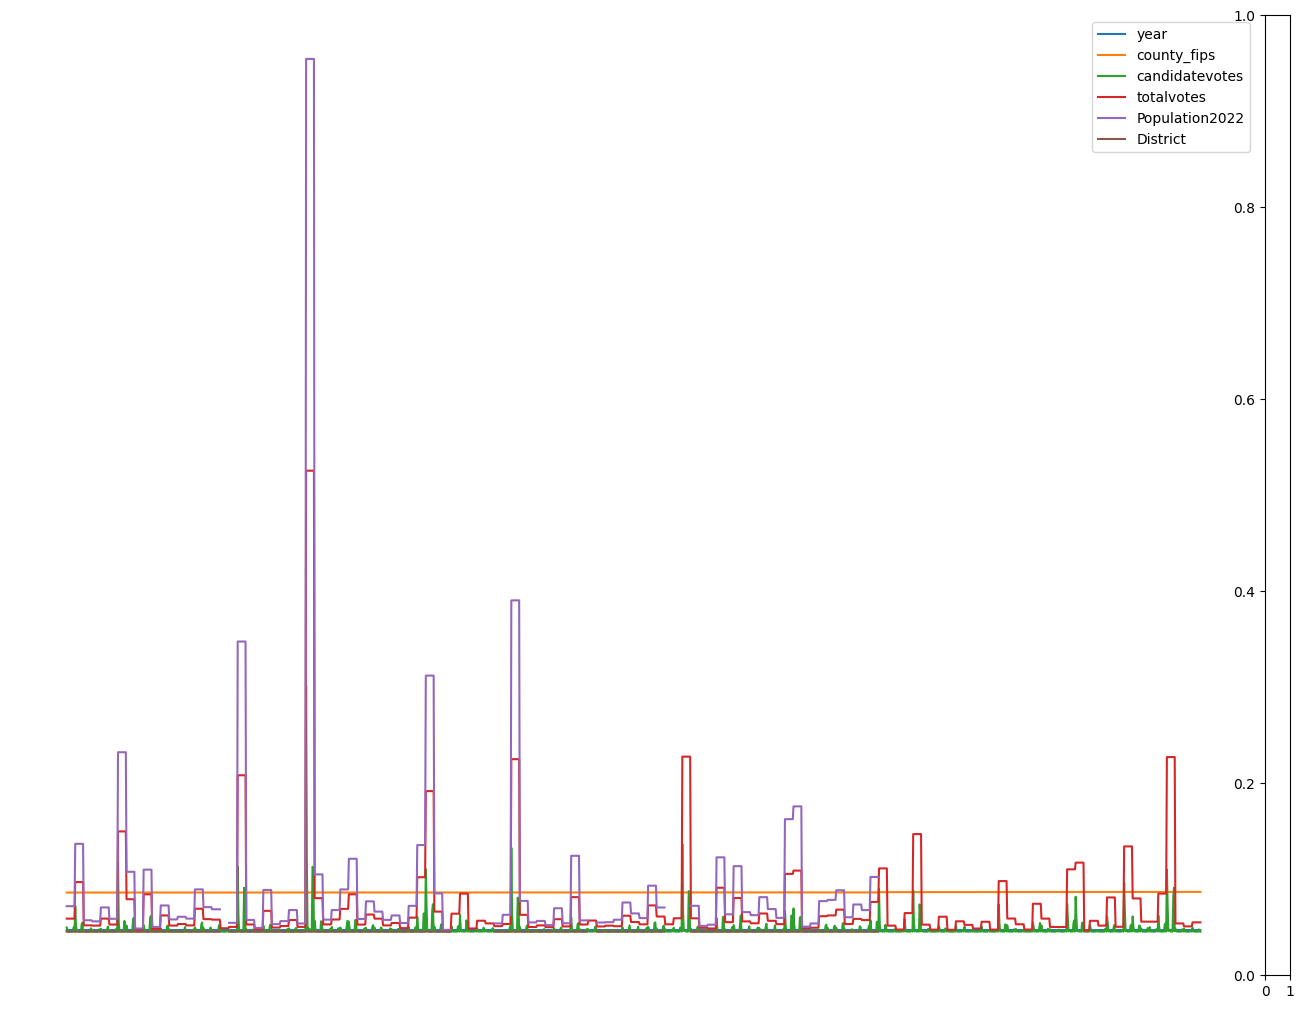

In [ ]:
#fig = plt.figure()
#ax = fig.add_axes([0, 0, 2, 2])
#divider = make_axes_locatable(ax)
#ax.axis('off')
#cax = divider.append_axes("right", size="2%", pad=0.08)
#voting_2022.plot(ax=ax,column='Population2022',legend=True)